# Проект

## Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

### Описание проекта
Стоит задача - в одном из развлекательных приложений Procrastinate Pro+ найти причину убытков, которые продолжаются уже несколько месяцев. Есть точная информация, что клиент вкладывает кучу денег в привлечение пользователей, но похоже, что все становится только хуже.  
  
Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

Сперва подгрузим библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline

Установим параметры отображения таблиц:
- количество строк в таблице было не больше 10;
- текст в ячейке отражался полностью вне зависимости от длины (это удобно, если в ячейке длинный заголовок или URL, которые хочется посмотреть);
- все числа отражались с двумя знаками после запятой;

In [3]:
pd.set_option('max_rows', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

Потом выгрузим данные в переменные.

In [4]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Посмотрим что из себя представляют данные.

In [5]:
visits.head(1)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


**`visits`** - лог сервера с информацией о посещениях сайт.  
  
6 столбцов и 309901 строк.  
Размер 14.2+ MB.  
  
Колонки:  
  
`User Id` — уникальный идентификатор пользователя  
`Device` — категория устройства пользователя  
`Session start` — дата и время начала сессии  
`Session End` — дата и время окончания сессии  
`Channel` — идентификатор рекламного источника, из которого пришел пользователь  
`Region` - страна пользователя  
  
  
Предобработка:  
1. Пустых значений нет  
2. Привести названия колонок к удобному формату  
3. Столбцы `Session Start` и `Session End` привести к формату даты 
4. Проверить на явные дубликаты 

In [7]:
orders.head(1)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


**`orders`** - информация о заказах.  
  
3 столбца и 40212 строк.  
Размер 942.6+ KB.  
  
Колонки:  
  
`User Id` — уникальный идентификатор пользователя  
`Event Dt` — дата и время покупки  
`Revenue` — выручка  
  
Предобработка:
1. Пустых значений нет
2. Привести названия колонок к удобному формату
3. Столбец `Event Dt` привести к формату даты
4. Проверить на явные дубликаты


In [9]:
costs.head(1)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


**`costs`** - информация о затратах на маркетинг.   
  
3 столбца и 1800 строк.  
Размер 42.3+ KB.  
  
Колонки:  
  
`Channel` — идентификатор рекламного источника  
`Dt` — дата  
`Costs` — затраты на этот рекламный источник в этот день  
  
Предобработка:
1. Пустых значений нет
2. Привести названия колонок к удобному формату
3. Столбец `Dt` привести к формату даты
4. Проверить на явные дубликаты

### Описание данных

Для проведения анализа нам был предоставлен лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27. Так же у нас есть выгрузка их покупок за этот период и статистика рекламных расходов.
  
В целом данные "чистые", без пропусков и с понятной структурой. Потребуется минимальная обработка для приведения их к рабочему виду.

**`visits`** - лог сервера с информацией о посещениях сайт.  
  
6 столбцов и 309901 строк.  
Размер 14.2+ MB.  
  
**Колонки**:  
  
* `User Id` — уникальный идентификатор пользователя  
* `Device` — категория устройства пользователя  
* `Session start` — дата и время начала сессии  
* `Session End` — дата и время окончания сессии  
* `Channel` — идентификатор рекламного источника, из которого пришел пользователь  
* `Region` - страна пользователя  
  
  
**Предобработка**:  
1. Пустых значений нет  
2. Привести названия колонок к удобному формату  
3. Столбцы `Session Start` и `Session End` привести к формату даты 
4. Проверить на явные дубликаты 

### Подготовка к анализу

#### Смена названия столбцов

In [11]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'ses_start', 'ses_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

#### Смена формата столбцов

In [12]:
visits['ses_start'] = pd.to_datetime(visits['ses_start'])
visits['ses_end'] = pd.to_datetime(visits['ses_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

#### Проверка дубликатов

Напишем функцию для проверки дубликатов.

In [13]:
def l_f_f_duplicates(data):
    
    # функция для поиска имени датафрейма
    def get_df_name(df):
        name =[x for x in globals() if globals()[x] is df][0]
        return name

    result = data.duplicated().sum()
    name = get_df_name(data)
    
    return f'В датафрейме {name} найдено {result} полных дубликатов.'

In [14]:
display(l_f_f_duplicates(visits))
display(l_f_f_duplicates(orders))
display(l_f_f_duplicates(costs))

'В датафрейме visits найдено 0 полных дубликатов.'

'В датафрейме orders найдено 0 полных дубликатов.'

'В датафрейме costs найдено 0 полных дубликатов.'

## Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

#### Функция для расчёта удержания

In [15]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'ses_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['ses_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта конверсии

In [16]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта LTV и ROI

In [17]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция для сглаживания фрейма

In [18]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации удержания

In [19]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1, colormap='Paired'
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2, colormap='Paired'
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3, colormap='Paired')
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4, colormap='Paired')
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция для визуализации конверсии

In [20]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1, colormap='Paired')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, colormap='Paired')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция для визуализации LTV и ROI

In [21]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1, colormap='Paired')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, colormap='Paired')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3, colormap='Paired')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4, colormap='Paired')
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5, colormap='Paired')
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Подготовка к анализу данных

Для выполнения данного шага нам потребуется создать профили пользователей. Для это мы сперва напишем функцию.

#### Функция для создания пользовательских профилей

In [22]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'ses_start'])
        .groupby('user_id')
        .agg(
            {
                'ses_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'ses_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    # меняем формат даты для слияния таблиц
    new_users['dt'] = pd.to_datetime(new_users['dt'])

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # меняем формат даты для слияния таблиц
    profiles['dt'] = pd.to_datetime(profiles['dt'])

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Создаем профили пользователей.

In [23]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


Устанавливаем момент и горизонт анализа данных.

In [24]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Теперь можно приступить к анализу. Сперва посмотрим сколько пользователей платит, а сколько нет.

In [25]:
profiles_users = profiles.groupby('payer').agg({'user_id': 'nunique'})
profiles_users

,user_id
payer,
False,141127
True,8881


In [26]:
conv = profiles_users['user_id'][1] / (profiles_users['user_id'][0] + profiles_users['user_id'][1])
round(conv, 3)

0.059

И так конверсия у нас чуть чуть не дотягивает до 6%.

### Анализ данных с разбивкой по странам

Посмотрим общее кол-во пользователей в каждой стране.

In [27]:
profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


> Ярко выраженная доминация пользователей из United States. Пользователей из любой другой страны в 5-7 раз меньше.

Посмотрим как ситуация обстоит с платными пользователями.

In [28]:

#Общее кол-во платящих
payer_all = (profiles.query('payer == True')
 .groupby('region').agg({'user_id': 'nunique'})
 .sort_values(by='user_id', ascending=False))

#Разбивка по устройствам
payer_dev = (profiles
 .query('payer == True')
 .pivot_table(
     index='region', 
     columns= 'device', 
     values='user_id', 
     aggfunc='nunique'))

#А теперь все вместе
payer_by_reg = pd.merge(payer_all, payer_dev, left_index=True, right_index=True)
payer_by_reg = payer_by_reg.rename(columns={'user_id':'users'})
payer_by_reg

,users,Android,Mac,PC,iPhone
region,,,,,
United States,6902,1487,1706,715,2994
UK,700,202,63,301,134
France,663,179,82,268,134
Germany,616,182,61,253,120


Платящих пользователей в США в 10 раз больше, чем в других регионах.  
Но такое доминирование одной страны может нивилировать успехи прочих регионов.

Посмотрим на цифры в соотнашении.
Сперва напишем функцию.

In [29]:
def part_of_users(data):
    def part_of_all(col):
        return round(payer_by_reg[col] / payer_by_reg['users'], 2) * 100
    
    for col in data.columns:
        if col != 'users':
            new_col = f'%_{col}'
            data[new_col] = part_of_all(col)

In [30]:
part_of_users(payer_by_reg)
payer_by_reg

,users,Android,Mac,PC,iPhone,%_Android,%_Mac,%_PC,%_iPhone
region,,,,,,,,,
United States,6902,1487,1706,715,2994,22.00,25.00,10.00,43.00
UK,700,202,63,301,134,29.00,9.00,43.00,19.00
France,663,179,82,268,134,27.00,12.00,40.00,20.00
Germany,616,182,61,253,120,30.00,10.00,41.00,19.00


- Очевидно, что в Америке доминирует Iphone, тогда как в других странах предпочтения больше отдают PC.  
- В Европе больше распространены телефоны на Android.
- Если бы не Америка, то Mac бы просто потерялся, уж очень мала его доля в Европе.

In [79]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='user_id', ascending=False)

,user_id,payer
region,,
United States,100002,0.07
UK,17575,0.04
France,17450,0.04
Germany,14981,0.04


### Анализ данных с разбивкой по устройствам

Посмотрим общее кол-во пользователей с разбивкой по разным устройствам.

In [31]:
(profiles.query('payer == True')
 .groupby('device').agg({'user_id': 'nunique'})
 .sort_values(by='user_id', ascending=False))

,user_id
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


Платящие пользователи чаще заходят с телефонов. В основном это Iphone. Реже всего с PC.

### Анализ данных с разбивкой по рекламным каналам

Смотрим общую разбивку по каналам привлечения.

In [32]:
(profiles.query('payer==True')
 .groupby('channel')
 .agg({'user_id': 'nunique'})
 .sort_values(by='user_id', ascending=False))

,user_id
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
...,...
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


Большая часть платящих пользователей приходила от FaceBoom, далее TipTop на третьем органический прирост.

### Вывод
Наша средняя конверсия около 6%.  
  
Для нас пользователь, который приносит деньги это:
- Гражданин Америки
- Использующий мобильный телефон, скорее всего Iphone
- Пришедший к нам из FaceBoom или TipTop, ну или случайно наткнулся

## Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Сколько денег потратили на рекламу

Посмотрим какие общие затраты на рекламу были у компании.

In [33]:
print(int(costs.agg({'costs': 'sum'})[0])) 

105497


Общая сумма составила 105497$.  
Посмотрим сколько вышло на одного пользователя.

In [34]:
costs_m = (profiles.query('channel != "organic"')
      .agg({'acquisition_cost': 'sum',  'user_id': 'nunique'}))
round(costs_m[1] / costs_m[0], 2)

0.89

In [88]:
round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)


1.13

In [87]:
(profiles.query('channel != "organic"').agg({'acquisition_cost': 'sum','user_id': 'nunique'}))

acquisition_cost   105497.30
user_id             93569.00
dtype: float64

Один пользователь нам обходится в 0.89$. Посмотрим как эта сумма изменяется в зависимости от подрядчика, региона и устройства.

#### Сколько денег потратили на рекламу по подрядчикам

In [35]:
costs_by_cha = (profiles.groupby('channel')
      .agg({'acquisition_cost': 'sum',  'user_id': 'nunique'})
      .sort_values(by='acquisition_cost', ascending=False)) 
costs_by_cha['user_cost'] = costs_by_cha['acquisition_cost'] / costs_by_cha['user_id']
costs_by_cha

,acquisition_cost,user_id,user_cost
channel,,,
TipTop,54751.30,19561,2.80
FaceBoom,32445.60,29144,1.11
WahooNetBanner,5151.00,8553,0.60
AdNonSense,3911.25,3880,1.01
OppleCreativeMedia,2151.25,8605,0.25
...,...,...,...
LeapBob,1797.60,8553,0.21
lambdaMediaAds,1557.60,2149,0.72
MediaTornado,954.48,4364,0.22


- Как и предполагалось, больше всего денег ушло на оплату подрядчикам TipTop и FaceBoom, гонорары остальных на порядок меньше.
- Самые дорогие пользователи приходят из TipTop, FaceBoom и AdNonSense. Причем стоимость пользователя в TipTop в 2.5 раза выше следующей компании по стоимости.

#### Сколько денег потратили на рекламу по месяцам

In [36]:
costs_m = (profiles.query('channel != "organic"')
           .groupby('month')
      .agg({'user_id': 'nunique', 'acquisition_cost': 'sum', }))
costs_m.columns =['users', 'costs']
costs_m['one_user'] = costs_m['costs']/costs_m['users']
costs_m = costs_m.sort_values(by='one_user', ascending=False)
print(costs_m)

            users    costs  one_user
month                               
2019-10-01  16049 20882.41      1.30
2019-09-01  17303 22441.34      1.30
2019-08-01  17545 20657.87      1.18
2019-07-01  14941 16447.06      1.10
2019-06-01  15315 15090.04      0.99
2019-05-01  12416  9978.57      0.80


Судя по всему стоимость привлечения одного пользователя неуклонно растет, как и общие затраты на рекламу.

#### Сколько денег потратили на рекламу по регионам

In [37]:
costs_m = (profiles.query('channel != "organic"')
           .groupby('region')
      .agg({'user_id': 'nunique', 'acquisition_cost': 'sum', }))
costs_m.columns =['users', 'costs']
costs_m['result'] = costs_m['costs']/costs_m['users']
costs_m = costs_m.sort_values(by='result', ascending=False)
costs_m

,users,costs,result
region,,,
United States,61829,90928.60,1.47
Germany,9528,4424.22,0.46
France,11058,5075.97,0.46
UK,11154,5068.50,0.45


Американские пользователи для компании в 2 раза дороже европейских.

#### Сколько стоило привлечение одного покупателя из каждого источника

In [38]:
costs_m = (profiles.groupby('channel')
      .agg({'user_id': 'nunique', 'acquisition_cost': 'sum', }))
costs_m.columns =['users', 'costs']
costs_m['result'] = costs_m['costs']/costs_m['users']
costs_m = costs_m.sort_values(by='result', ascending=False)
print(costs_m)

                    users    costs  result
channel                                   
TipTop              19561 54751.30    2.80
FaceBoom            29144 32445.60    1.11
AdNonSense           3880  3911.25    1.01
lambdaMediaAds       2149  1557.60    0.72
WahooNetBanner       8553  5151.00    0.60
...                   ...      ...     ...
OppleCreativeMedia   8605  2151.25    0.25
YRabbit              4312   944.22    0.22
MediaTornado         4364   954.48    0.22
LeapBob              8553  1797.60    0.21
organic             56439     0.00    0.00

[11 rows x 3 columns]


### Выводы

- За отчетный период компания потратила 105497$ на рекламу.
- У компании есть 2 генеральных подрядчика TipTop и FaceBoom, а так же несколько более мелких.
- Траты на рекламу в компании постоянно растут.
- Больше всего компания вкладывает в рекламу в Америке.
- Самые дорогие пользователи приходят от TipTop, FaceBoom, AdNonSense.

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

Сперва удалим органически пришедших пользователей. На них окупаемость рекламы никак не влияет.

In [39]:
profiles_no = profiles.query('channel != "organic"')

В начале анализа построим несколько общих графиков для понимания ситуации в целом.

Сперва применим функцию удержания пользователей.

In [40]:
retention_raw, retention, retention_history = get_retention(
    profiles_no,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

И построим по ней графики.

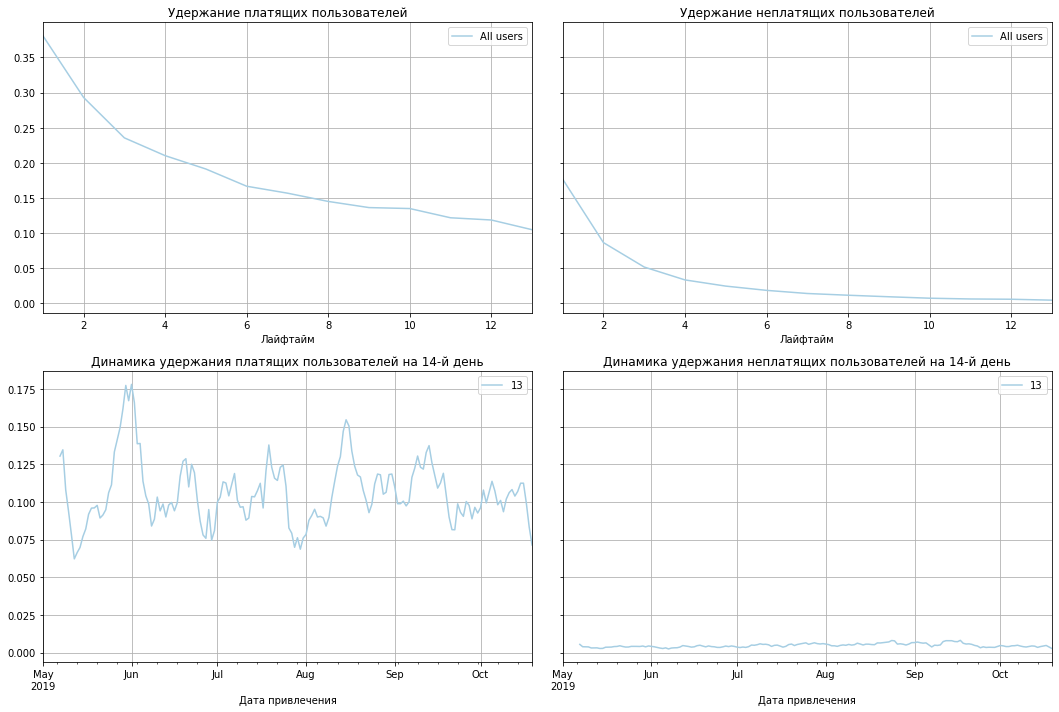

In [41]:
plot_retention(retention, retention_history, horizon_days, window=7)

#### Краткие выводы по удержанию

- Удержание платящих пользователей выше чем не платящих
- Со временем удержание пользователей уменьшается, что нормально
- К концу второй недели коэффициент удержания платящих пользователей равен 0.11
- Удержание платящих пользователей относительно стабильно с течением времени, но имеет сезонность

Применим функцию конверсии.

In [42]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_no,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

И построим графики.

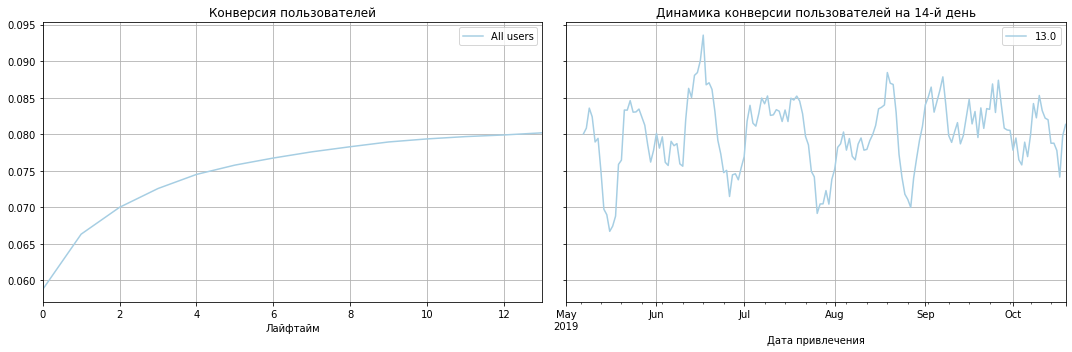

In [43]:
plot_conversion(conversion, conversion_history, horizon_days, window=7)

#### Краткие выводы по конверсии

- К концу второй недели конверсия пользователей равна 8%
- В июне была самая лучшая конверсия

Применяем функцию для расчета LTV и ROI.

In [44]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days
)

На основании полученных данных построим графики.

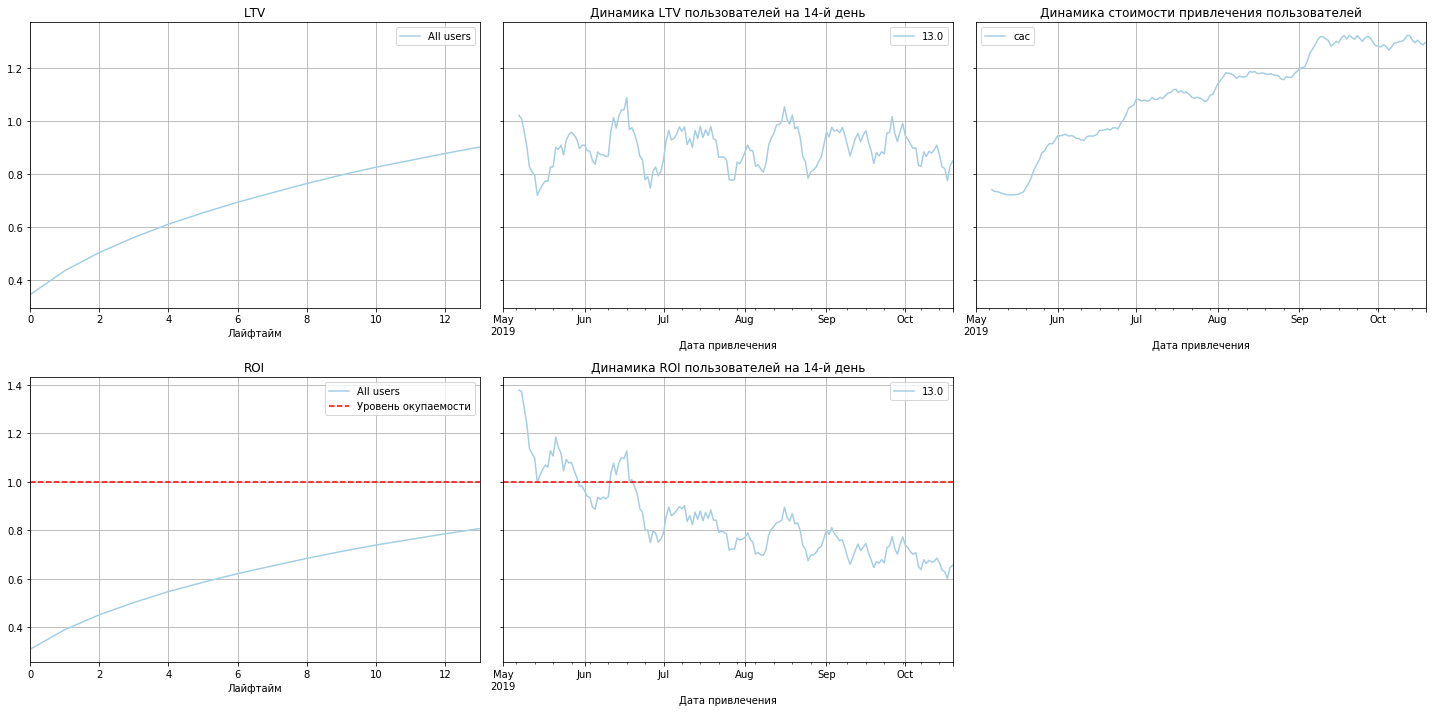

In [45]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

#### Краткие выводы LTV и ROI

- LTV подвержено сезонности
- LTV стабилен
- Работа маркетинговой службы изначально была неправильно выстроена
- Стоимость привлечения пользователей постоянно растет
- Реклама не окупается к концу второй недели 
- Начиная с июня компания терпит убытки на рекламных пользователях

Графики говорят о проблемах в стоимости привлечения пользователей.  
Проведем более глубокий анализ с разбивкой по странам, устройствам и каналам привлечения.

### Проанализируйте окупаемость рекламы с разбивкой по странам

Задаем параметр разбивки по странам.

In [46]:
dimensions = ['region']

Построим график, чтобы понять как распределялся во времени приток пользователей из разных стран.

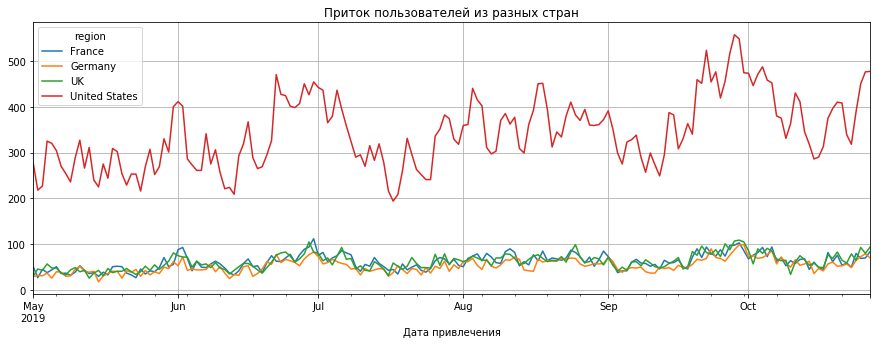

In [47]:
profiles_no.pivot_table(
    index='dt',  
    columns='region',  
    values='user_id',  
    aggfunc='nunique',  
).plot(figsize=(15, 5), grid=True)
plt.xlabel('Дата привлечения')
plt.title('Приток пользователей из разных стран');

Приток из всех стран был стабилен с многократной доминацией United States.  
Посмотрим как происходит удержание в разных странах.  
Применим функцию удержания.

In [48]:
retention_raw, retention, retention_history = get_retention(
    profiles_no,
    visits,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
)

И построим график.

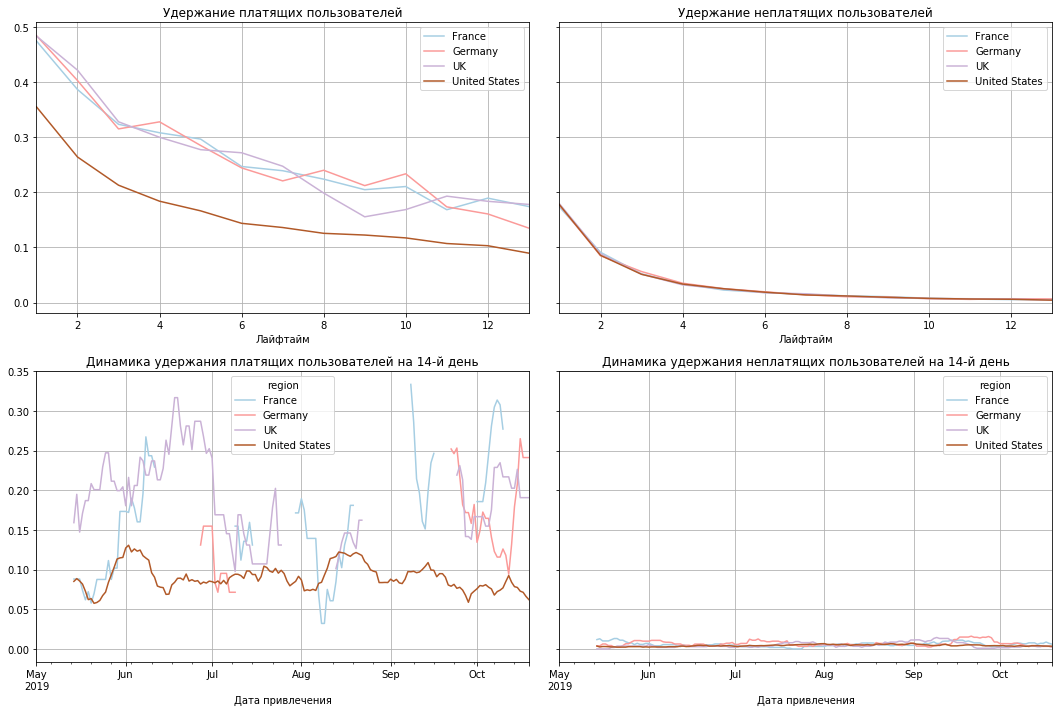

In [49]:
plot_retention(retention, retention_history, horizon_days, window=14)

#### Краткие выводы по удержанию с разбивкой по регионам

- Удержание платящих пользователей из United States хуже чем в других странах
- К концу второй недели коэффициент удержание пользователей из United States в 2 раза ниже, чем из других стран
- Плохо развито привлечение новых пользователей из Европы, существуют сезонные пробелы

Применим функцию конверсии.

In [50]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_no,
    orders,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
)

График.

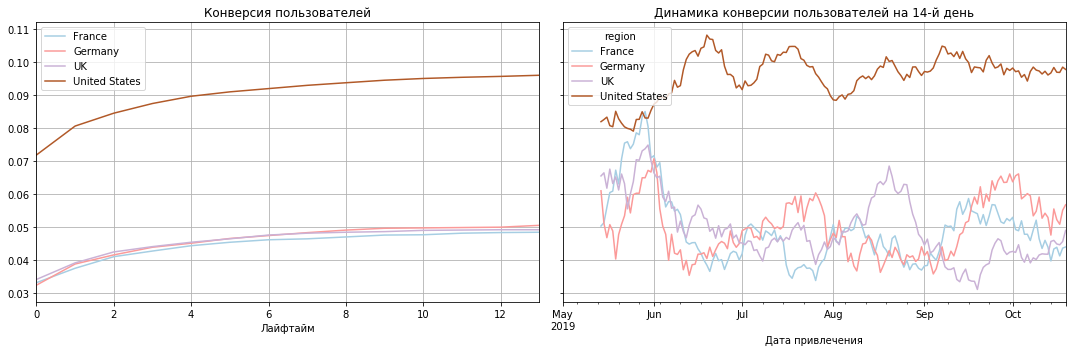

In [51]:
plot_conversion(conversion, conversion_history, horizon_days, window=14)

##### Краткие выводы по конверсии с разбивкой по странам

- Самая лучшая конверсия в United States, к концу второй недели около 9.5%
- В остальных странах конверсия составляет около 5% к концу второй недели
- Наблюдается сезонность в динамике конверсии

Применяем функцию для расчета LTV и ROI.

In [52]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

На основании полученных данных построим графики.

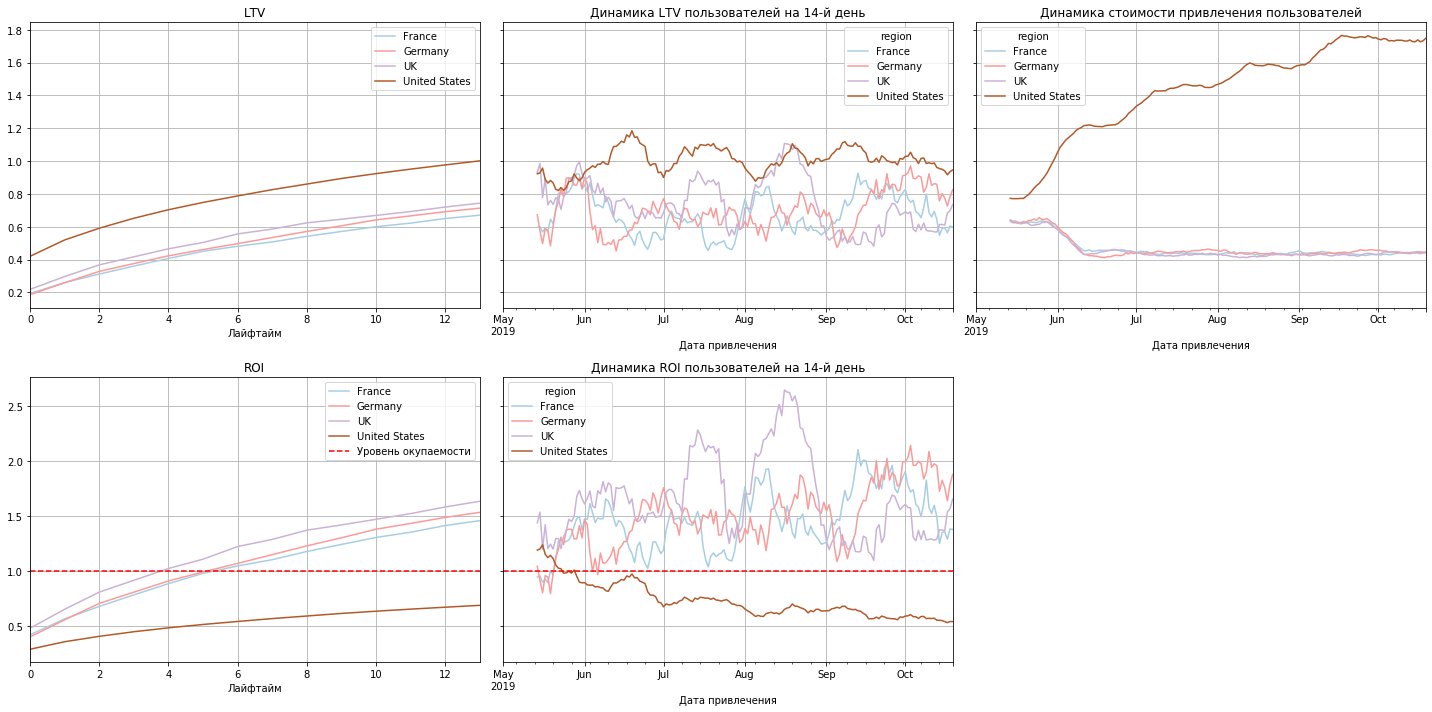

In [53]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Краткие выводы по LTV и ROI с разбивкой по регионам

- LTV подвержено периодичности
- Лучшие показатели по LTV у United States 
- Остальные страны приблезительно равны по LTV
- Реклама во всех странах стоит приблизтельно одинаково, кроме United States
- У United States стоимость рекламы неуклонно растет, тогда как в других странах падает
- Реклама во всех странах начинают окупаться приблизительно на 5 день, кроме United States, там она не окупается
- Все страны стабильно окупаются с разным успехом, в зависимости от сезонности, кроме United States
- United States не окупается с мая

#### Гипотеза
Стоимость привлечения новых пользователей в Америке слишком завышена.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

Задаем параметр разбивки по устройствам.

In [54]:
dimensions = ['device']

Построим график, чтобы понять как распределялся во времени приток пользователей на разных устройствах.

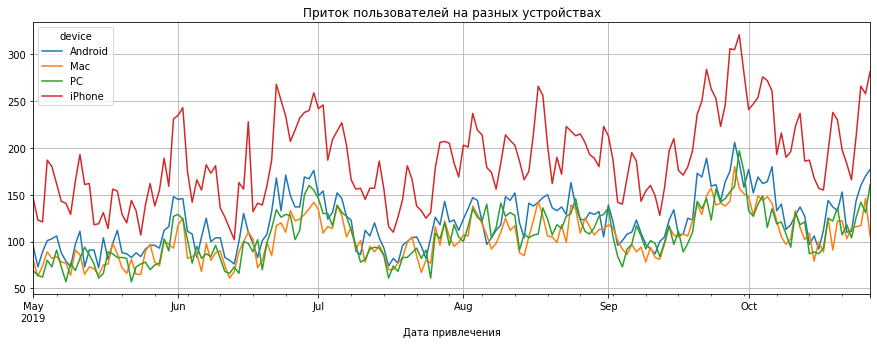

In [55]:
profiles_no.pivot_table(
    index='dt',  
    columns='device',  
    values='user_id',  
    aggfunc='nunique',  
).plot(figsize=(15, 5), grid=True)
plt.xlabel('Дата привлечения')
plt.title('Приток пользователей на разных устройствах');

Ярко выраженная доминация пользователей на Iphone. Пользователи, использующие другие устройства, отстают от фаворитов в 2 раза.  
Посмотрим как выглядит ситуация с удержанием.

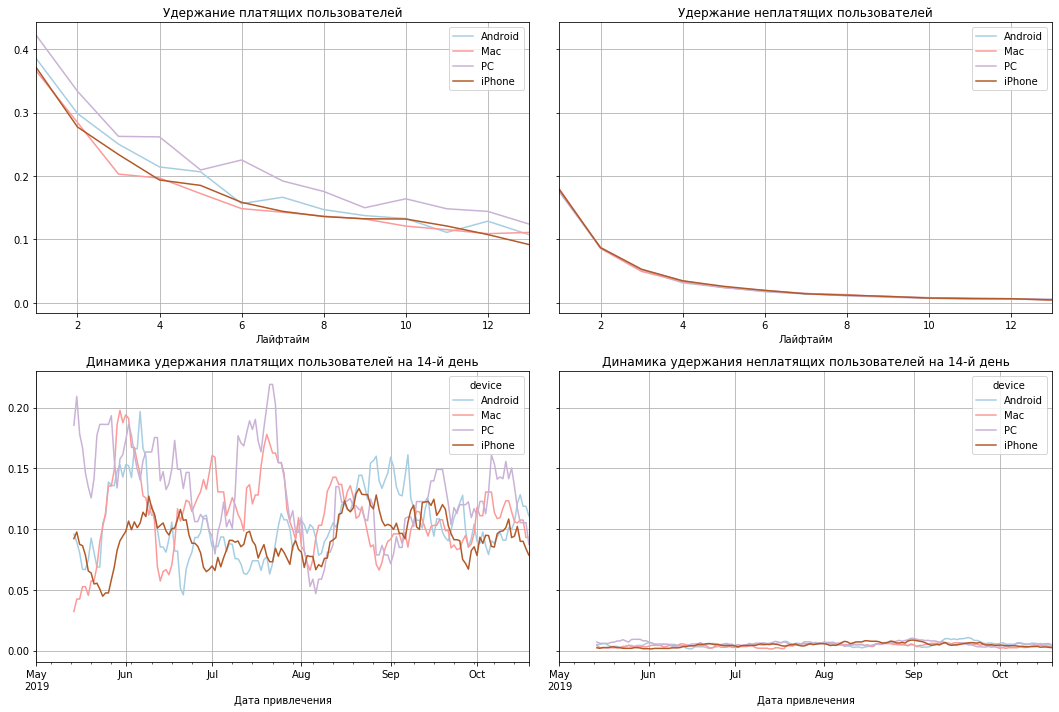

In [56]:
retention_raw, retention, retention_history = get_retention(
    profiles_no,
    visits,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
)
plot_retention(retention, retention_history, horizon_days, window=14)

#### Краткие выводы по удержанию с разбивкой по устройствам

- Удержание на всех устройствах примерно одинаково
- К концу второй недели коэффициент удержание находится в районе 0.1 - 0.16
- На PC c мая по август наблюдались лучшие результаты удержания по прошествию 14 дней выше

Посмотрим на конверсию.

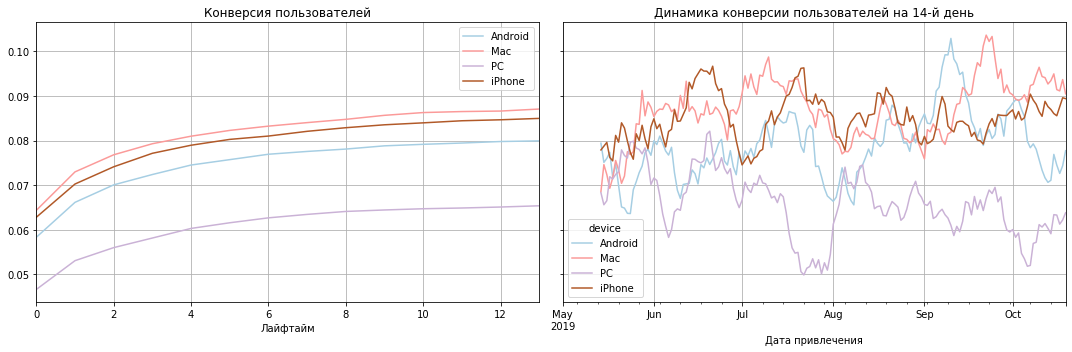

In [57]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_no,
    orders,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
)
plot_conversion(conversion, conversion_history, horizon_days, window=14)

#### Краткие выводы по конверсии с разбивкой по устройствам

- Самая худшая конверсия у PC, к концу второй недели около 6.5%
- На остальных устройствах конверсия составляет около 8-9% к концу второй недели
- Наблюдается сезонность в динамике конверсии

Применяем функцию для расчета LTV и ROI.

In [58]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

На основании полученных данных построим графики.

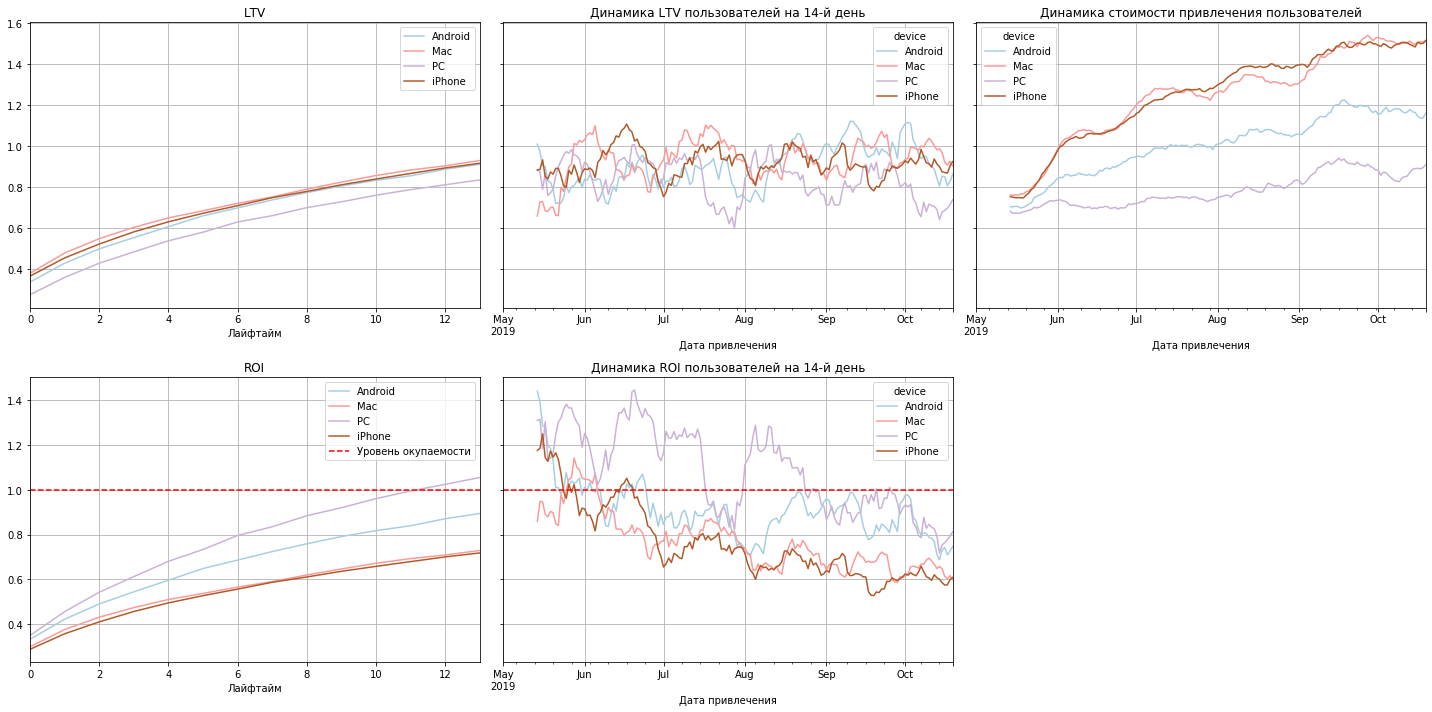

In [59]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Краткие выводы по LTV и ROI с разбивкой по устройствам

- LTV слабо подвержено сезонности
- Худшие показатели у PC около 0.8 к концу второй недели
- На остальных устройствах LTV примерно одинаков и составляет 0.9 к концу второй недели 
- Больше всего растут затраты на рекламу на Iphone и Mac
- Дешевле всего обходятся пользователи на PC
- На всех устройствах стоимость привлечения неуклонно растет
- К концу второй недели окупаются только PC, остальные нет
- Динамика окупаемости постоянно снижается

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

Задаем параметр разбивки по рекламным каналам.

In [60]:
dimensions = ['channel']

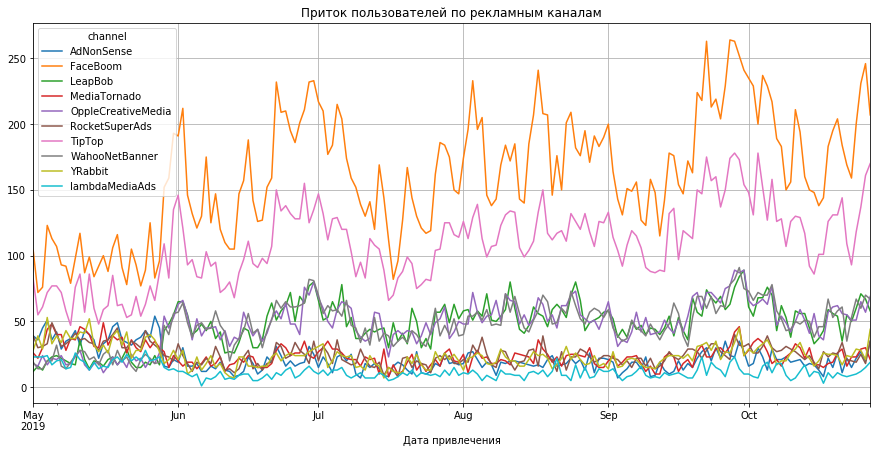

In [61]:
profiles_no.pivot_table(
    index='dt',  
    columns='channel',  
    values='user_id',  
    aggfunc='nunique',  
).plot(figsize=(15, 7), grid=True)
plt.xlabel('Дата привлечения')
plt.title('Приток пользователей по рекламным каналам');

Видна доминирующая позиция FaceBoom и TipTop.  
Посмотрим на удержание.

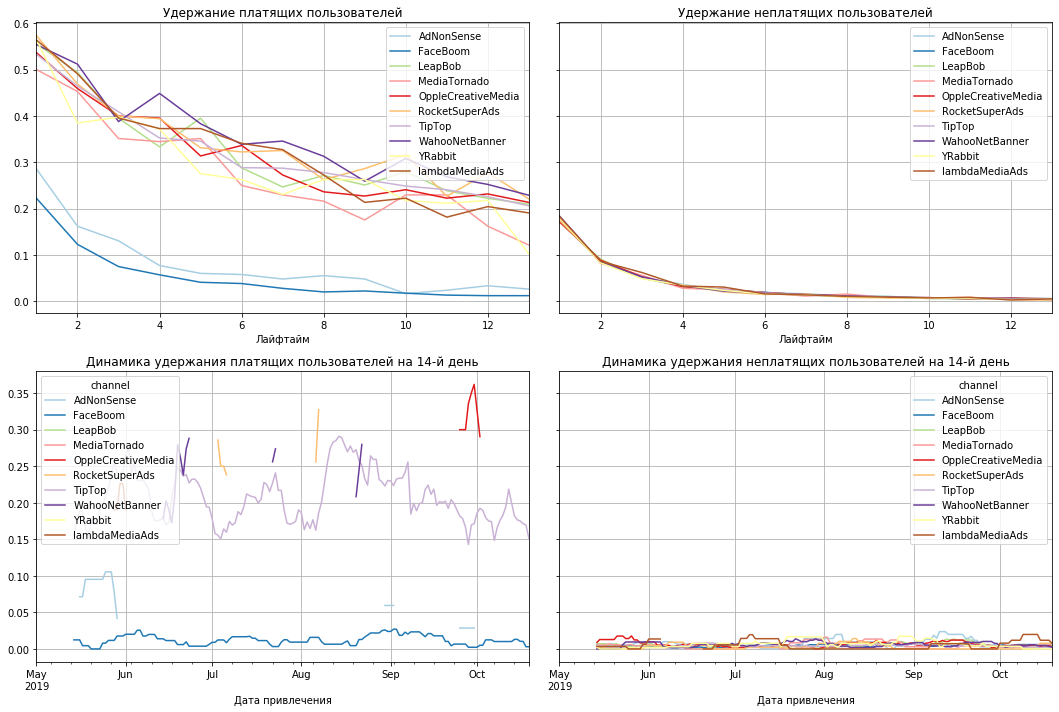

In [62]:
retention_raw, retention, retention_history = get_retention(
    profiles_no,
    visits,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
)
plot_retention(retention, retention_history, horizon_days, window=14)

#### Краткие выводы по удержанию с разбивкой по устройствам

- FaceBoom и AdNonSence не могут похвастаться хорошим удержанием
- У остальных партнеров удрежание равно и составляет примерно 0.2-0.3 к концу второй недели
- Стабильно реклама заказывается только у FaceBoom и TipTop

Посмотрим на конверсию.

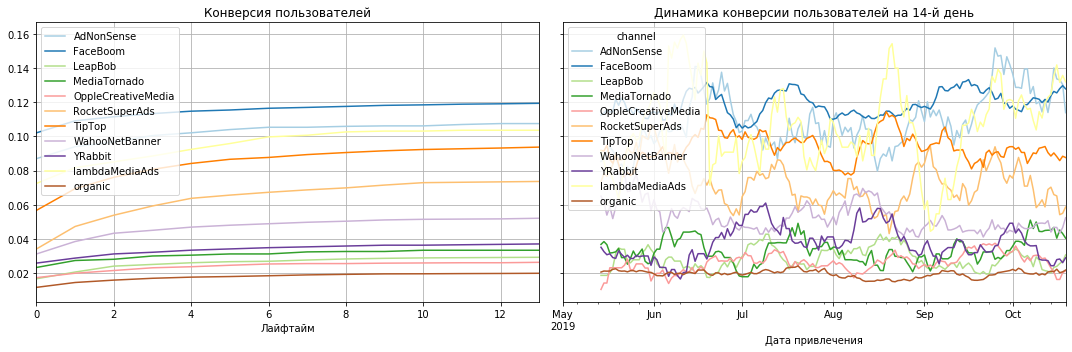

In [63]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
)
plot_conversion(conversion, conversion_history, horizon_days, window=14)

#### Краткие выводы по конверсии с разбивкой по устройствам

- Самая худшая конверсия у органики, к концу второй недели меньше 2%
- Лучше всего конвертируются FaceBoom - 12%, AdNonSence - 10.5%, lambdaMediaAds - 10%, TipTop - 9.5% и RocketSuperAds - 7%
- Наблюдается сезонность в динамике конверсии

Применяем функцию для расчета LTV и ROI и построим графики.

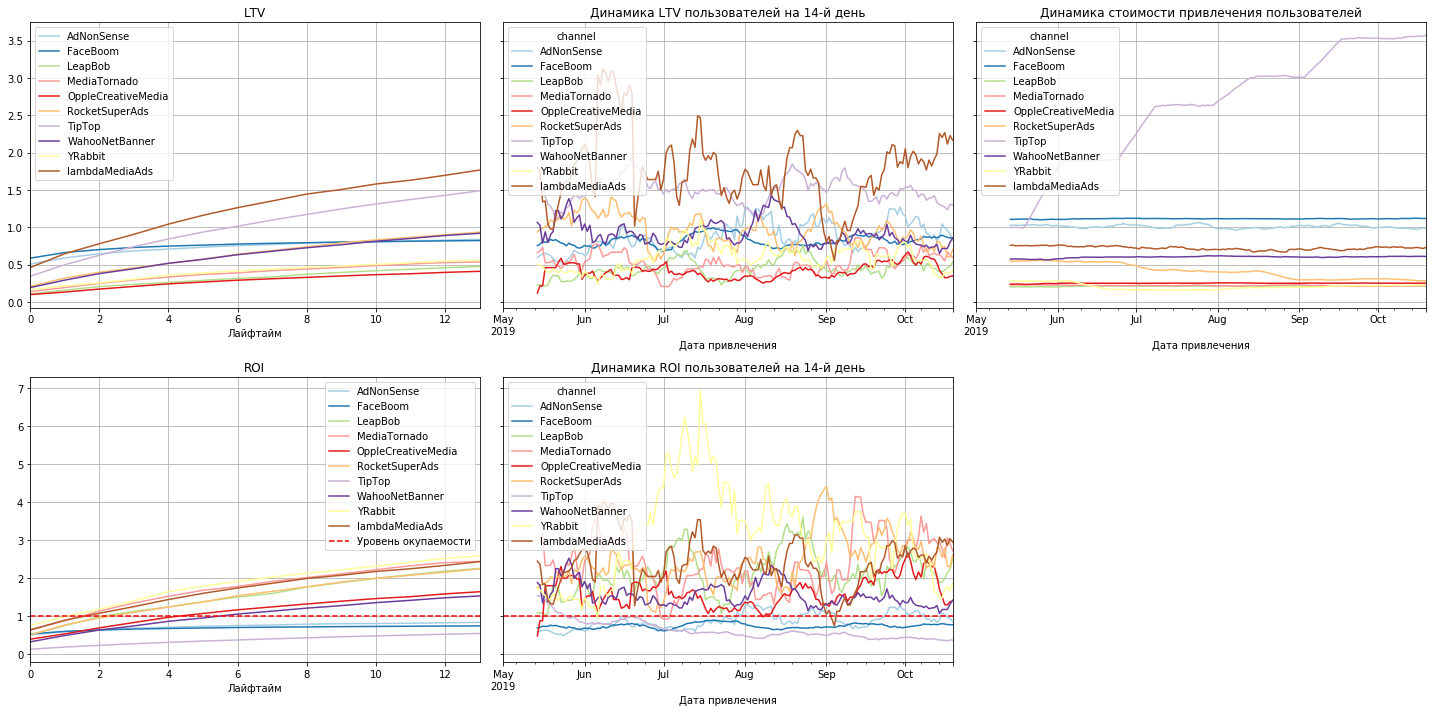

In [64]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Краткие выводы по LTV и ROI с разбивкой по устройствам

- LTV сильно подвержено сезонности
- Лучшие показатели у lambdaMediaAds - 1.7, TipTop -1.5, WahooNetBanner - 0.9, FaceBoom - 0.8
- От остальных источников LTV примерно одинаков и составляет 0.5 к концу второй недели 
- Больше всего растут затраты на рекламу у TipTop, затраты с начала периода выросли в 3.5 раза, у остальных они стабильны
- Стабильно не окупаются TipTop, FaceBoom, AdNonSense
- OppleCrativeMedia и WahooNetBanner окупаются примерно в 1,5 раза, Остальные в 2 раза к концу второй недели
- TipTop, FaceBoom, AdNonSense стабильно не окупаются в течении всего срока

#### Гипотеза
Существует проблема в работе с подрядчиками TipTop, FaceBoom, AdNonSense. На протяжении всего срока вложения в клиентов от данных организаций не окупаются. Учитывая предыдущую гипотезу, понять связан ли регион Америка с этими подрядчиками.

### Частичная проверка американской гипотезы

Попробуем отфильтровать клиентов из Америки и посмотреть какими подрядчиками они были привлечены.

In [65]:
(profiles.query('region == "United States"')
     .groupby('channel')
     .agg({'user_id': 'nunique'})
     .sort_values(by='user_id', ascending=False)
)

,user_id
channel,
organic,38173
FaceBoom,29144
TipTop,19561
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


#### Гипотеза
2 из 3, мы не можем отклонить основную гипотезу о совпадении подрядчиков TipTop и FaceBoom с регионом Америка. Соотевтственно пока мы принимаем, что два этих подрядчика, приноящих основной приток пользователей из Америки (не считая бесплатной органики) приносят убыток нашей фирме.

Сперва фильтруем по региону.

In [66]:
profiles_hip_am = profiles.query('region == "United States"')

Потом пишем функцию для заполнения нового поля таблицы.

In [67]:
def hip_a_col(row):
    hip = ['TipTop', 'FaceBoom']
    if row['channel'] in hip:
        return 'hipo'
    else:
        return 'other'

И применяем ее.

In [68]:
profiles_hip_am['test'] = profiles_hip_am.apply(hip_a_col, axis=1)

Посмотрим что у нас по распределению.

In [69]:
(profiles_hip_am.groupby('test')
     .agg({'user_id': 'nunique'})
     .sort_values(by='user_id', ascending=False)
)

,user_id
test,
other,51297
hipo,48705


Практически половина пользователей из этих двух источников.
А что будет если убрать органику.

In [70]:
(profiles_hip_am.query('channel != "organic"')
     .groupby('test')
     .agg({'user_id': 'nunique'})
     .sort_values(by='user_id', ascending=False)
)

,user_id
test,
hipo,48705
other,13124


В 3 раза больше пользователей из проверяемых компания, чем из прочих. Пора строить графики.  
Я думаю в данном случае нам достточно будет LTV и ROI.

In [71]:
profiles_hip_am_no_organic = profiles_hip_am.query('channel != "organic"')

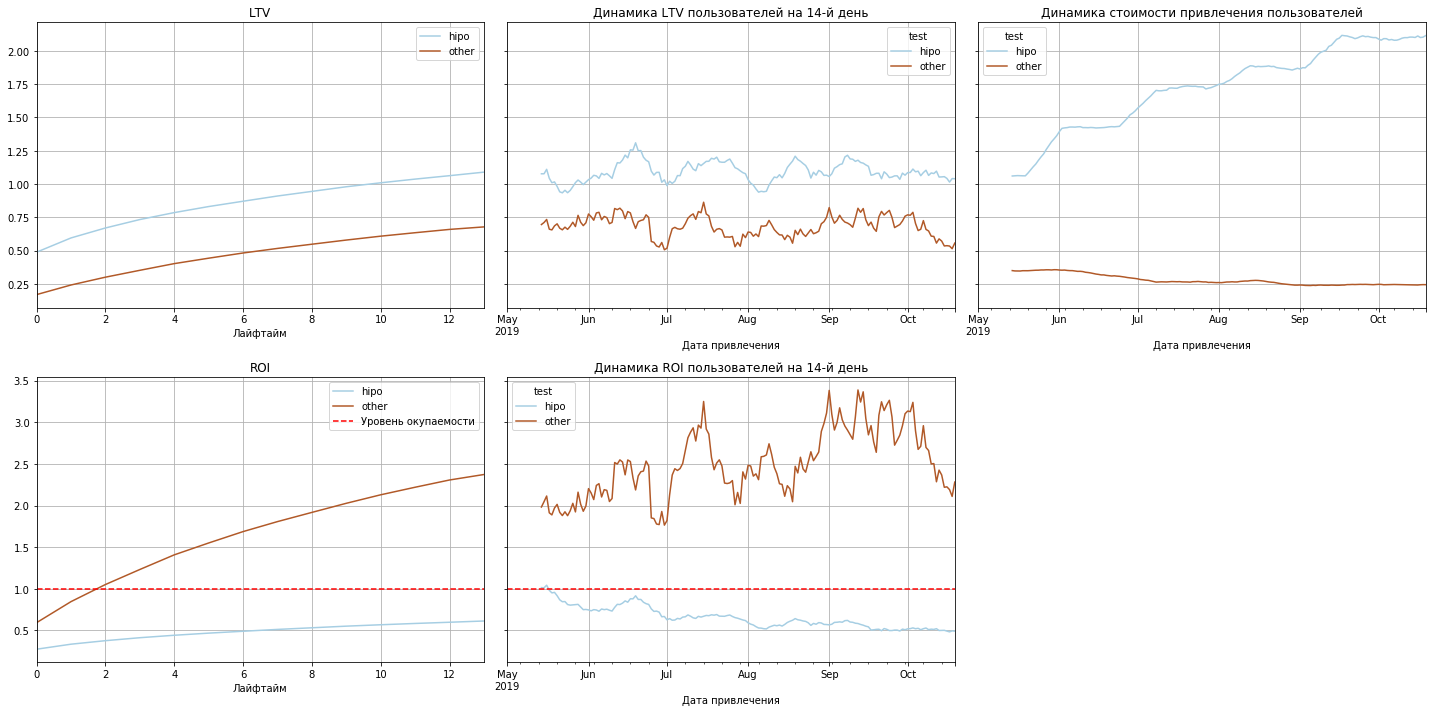

In [72]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_hip_am_no_organic, orders, observation_date, horizon_days, dimensions=['test']
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Что и требовалось доказать, они конечно хорошо живут, но плохо платят.

#### Первончальный вывод по американской гипотезе
Мы не смогли опровергуть основную гипотезу о вреде, который приносят компании TipTop и FaceBoom в Америке. 
- Судя по всему это основной источник привлечения клиентов, при этом клиенты стабильно не окупаются. 
- Из прочих источников окупаемость составляет чуть меньше 2.5 к концу второй недели. 
- При этом расходы на привлечение "плохих" пользователей постоянно растут, что рано или поздно нас похоронит.

### Частичная проверка европейской гипотезы по подрячику AdNonSense

Проверим из какого региона наш третий подрядчик.

In [73]:
(profiles.query('channel == "AdNonSense"')
     .groupby('region')
     .agg({'user_id': 'nunique'})
     .sort_values(by='user_id', ascending=False)
)

,user_id
region,
France,1366
UK,1295
Germany,1219


#### Гипотеза
Основная гипотеза по подрядчику AdNonSense (ха-ха бессмысленная реклама) не подтвердилась. Выставляем новую гипотизу: данный подрядчик портит нам всю малину в прочих регионах, кроме Америки.

Попробуем проверить.  
Для начала так же уберем органику и Америку из профилей.

In [74]:
profiles_hip_eu = profiles.query('(region != "United States") & (channel != "organic")')

Напишем новую функцию для датасета и применим ее.

In [75]:
def hip_eu_col(row):
    hip = ['AdNonSense']
    if row['channel'] in hip:
        return 'hipo'
    else:
        return 'other'

In [76]:
profiles_hip_eu['test'] = profiles_hip_eu.apply(hip_eu_col, axis=1)

Проверим результаты.

In [77]:
(profiles_hip_eu.groupby(['test', 'region'])
     .agg({'user_id': 'nunique'})
     .sort_values(by='user_id', ascending=False)
)

user_id
test  region          
other UK          9859
      France      9692
      Germany     8309
hipo  France      1366
      UK          1295
      Germany     1219

Здесь ситуация не так плачевна, плохих пользователей все же меньшее чем хороших. Так же по регионам распределение примерно одинаково, поэтому при построении графиков не будем разбивать на регионы дополнительно.  
Строим LTV и ROI.

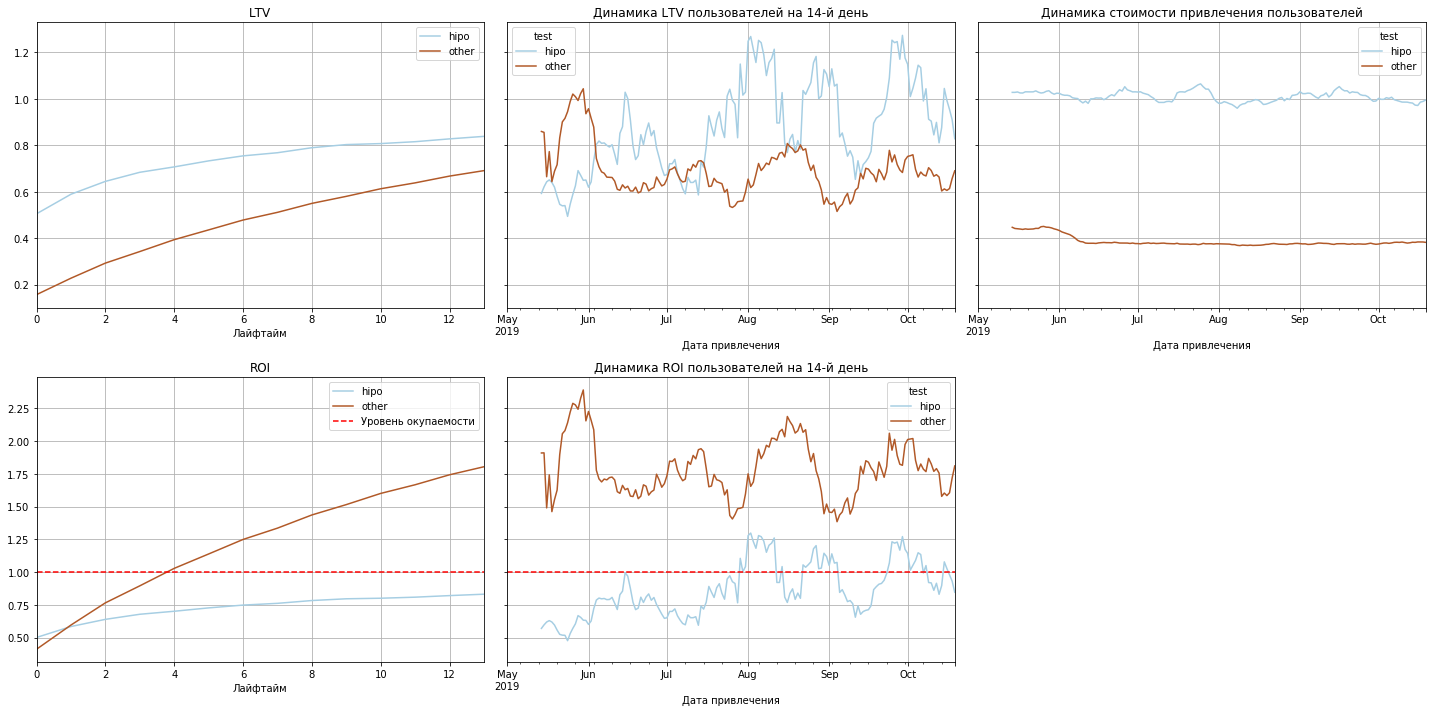

In [78]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_hip_eu, orders, observation_date, horizon_days, dimensions=['test']
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Первончальный вывод по европейской гипотезе
Мы не смогли опровергуть основную гипотезу о вреде, который приносит компания AdNonSense в Европе. 
- Это не основной источник привлечения клиентов, при этом клиенты стабильно не окупаются. 
- Из прочих источников окупаемость составляет около 1.8 к концу второй недели. 
- Расходы на привлечение пользователей от подрядчика AdNonSense не растут, но они стабильно выше прочих в 2 раза.

### Выводы
Выполняя данный анализ мы выяснили, что у компании проблемы с тратами на рекламу. Мы не смогли опровергнуть обе гипотезы:

> Предварительно мы принимаем, что подрядчики TipTop и FaceBoom, приноящие основной приток пользователей из Америки (не считая бесплатной органики) приносят убыток нашей фирме.

> Предварительно мы принимаем, что подрядчик AdNonSense, приноящий пользователей из Европы приносят убыток нашей фирме.  
  
Так же мы выяснили:
- У нас неплохая конверсия 8%, по прошествии двух недель;
- Реклама не окупается к концу второй недели;
- Начиная с июня компания терпит убытки на рекламных пользователях;
- Стоимость привлечения пользователей постоянно растет;
---
- Наши пользователи в основном из Америки, при этом они не задерживаются у нас надолго;
- Самая лучшая конверсия в Америке, к концу второй недели около 9.5%, в остальных странах около 5%;
- Плохо развито привлечение новых пользователей из Европы, существуют сезонные пробелы;
- Американцы платят лучше всего;
- Стоимость рекламы в Америке стабильно растет, тогда как в других странах падает;
- Реклама во всех странах стоит приблизтельно одинаково, кроме Америки;
- Все страны стабильно окупаются, опять же кроме Америки;
---
- Мы равномерно представлены на устройствах: Андроид, ПК и Мак;
- Пользователи, пользующиеся Айфоном в 2 раза превышают прочих;
- Удержание на всех устройствах приблизительно равно;
- На ПК конверсия около 6.5%, на остальных устройствах около 8-9% к концу второй недели;
- LTV у всех примерно одинаково - 0.9, но хуже всех у PC - 0.8;
- Самые дорогие пользователи приходят на Mac и Iphone;
- Дешевле всего нам обходятся пользователи на PC;
- Динамика окупаемости постоянно снижается;
---
- FaceBoom и AdNonSence не могут похвастаться хорошим удержанием;
- У остальных партнеров удрежание равно и составляет примерно 0.2-0.3 к концу второй недели;
- Лучше всего конвертируются FaceBoom - 12%, AdNonSence - 10.5%, lambdaMediaAds - 10%, TipTop - 9.5% и RocketSuperAds - 7%;
- Лучшие показатели LTV у lambdaMediaAds - 1.7, TipTop -1.5, WahooNetBanner - 0.9, FaceBoom - 0.8 на конец второй недели;
- От остальных источников LTV примерно одинаков и составляет 0.5 к концу второй недели; 
- Больше всего растут затраты на рекламу у TipTop, затраты с начала периода выросли в 3.5 раза, у остальных они стабильны;
- Стабильно не окупаются TipTop, FaceBoom, AdNonSense;
- Окупаемость OppleCrativeMedia и WahooNetBanner примерно 1.5, остальные 2 к концу второй недели;
- К концу второй недели лучше всего окупаются PC, едва окупаются Android, Mac и Iphone не окупаются;
- TipTop, FaceBoom, AdNonSense стабильно не окупаются в течении всего срока подряда;

## Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

**Наш пользователь** - американец с мобильным телефоном, пришедший из FaceBoom, TipTop или по своей воле.  

---  
Исходя из этой информации наши взгляды в первую очередь должны быть направлены в сторону Америки и данных подрядчиков. Однако мы позволили себе раздуть стоимость привлечения пользователей в 3 раза по сравнению с Европой, что делает невозможным окупаемость в Штатах, даже при том, что они конвертитуются и платят лучше всех.  

 --- 
Так же у нас существует проблема с подрядчиком AdNonSense в Европе, он стоит нам в 2 раза дороже остальных европейских партнеров. При этом его вклад в общую картину не более 20%, что дает нам возможность в кратчайшие сроки найти альтернативу.  

---  
В целом, решив проблему с двумя американскими и одним европейским подрячками, а точнее со стоимостью их услуг, мы выйдем на окупаемость в 2.5, что соответствует окупаемости прочих наших платных клиентов.  

---
Так же, надо учитывать, что 40% наших пользователей пришло органическим путем, что уже дает неплохой запас отделу маркетинга.